In [1]:
%matplotlib inline
!nvidia-smi


Tue Nov 28 07:21:16 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.17                 Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:02:00.0 Off |                  N/A |
|  0%   45C    P8               3W /  65W |    149MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import cv2
import time
import matplotlib.pyplot as plt
import cProfile
import numpy as np
%load_ext line_profiler
%load_ext memory_profiler

Time taken: 0.60 seconds


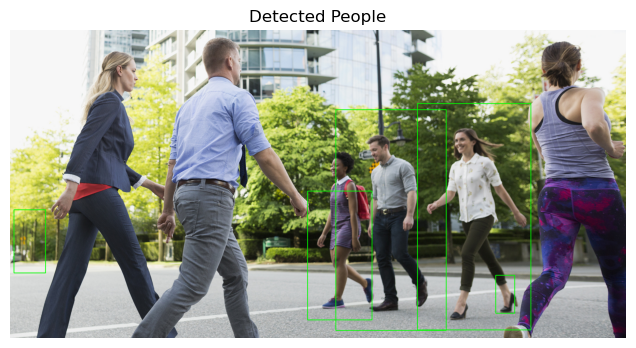

In [18]:
# Load the pre-trained SVM model for person detection
hog_detector = cv2.HOGDescriptor()
hog_detector.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Load image
image = cv2.imread('C:\\Users\\Micha\\opencv_installation\\people.jpg')

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Start the timer
start_time = time.time()

# Detect people in the image
boxes, weights = hog_detector.detectMultiScale(gray_image, winStride=(8, 8), padding=(8, 8), scale=1.05)

# Stop the timer
end_time = time.time()

# Calculate the duration
duration = end_time - start_time
print(f"Time taken: {duration:.2f} seconds")

# Draw bounding boxes around detected people
for (x, y, w, h) in boxes:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result
plt.figure(figsize=(8, 4))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Detected People')
plt.axis('off')
plt.show()

Time taken: 0.53 seconds


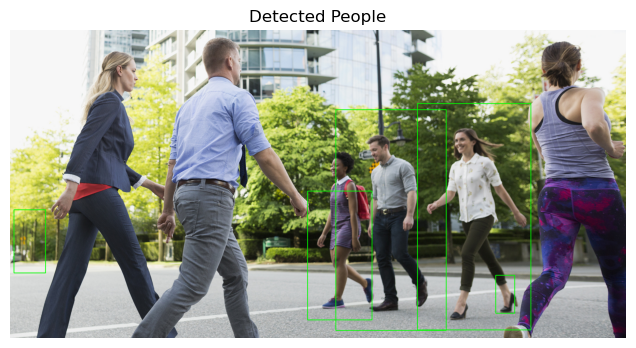

In [13]:
#Partial cuda implementation in HOG
# Load the pre-trained SVM model for person detection
hog_detector = cv2.HOGDescriptor()
hog_detector.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Load image
image = cv2.imread('C:\\Users\\Micha\\opencv_installation\\people.jpg')

# Upload image to GPU
gpu_image = cv2.cuda_GpuMat()
gpu_image.upload(image)

# Convert to grayscale on GPU
gpu_gray = cv2.cuda.cvtColor(gpu_image, cv2.COLOR_BGR2GRAY)

# Download the image back to CPU for HOG detection
cpu_gray = gpu_gray.download()

# Start the timer
start_time = time.time()

# Detect people in the image
boxes, weights = hog_detector.detectMultiScale(cpu_gray, winStride=(8, 8), padding=(8, 8), scale=1.05)

# Stop the timer
end_time = time.time()

# Calculate the duration
duration = end_time - start_time
print(f"Time taken: {duration:.2f} seconds")

# Draw bounding boxes around detected people
for (x, y, w, h) in boxes:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result
plt.figure(figsize=(8, 4))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Detected People')
plt.axis('off')
plt.show()

Time taken for corner detection: 0.0315556526184082 seconds


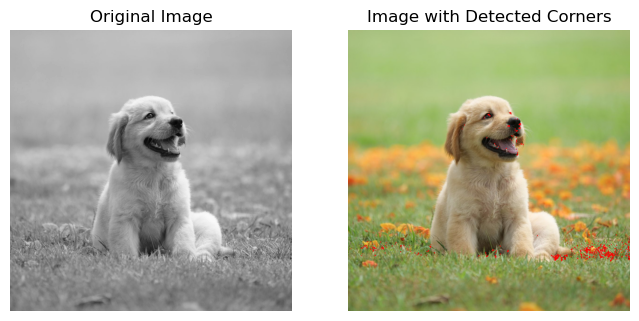

In [4]:
# Load image
image = cv2.imread('C:\\Users\\Micha\\opencv_installation\\puppy.jpg')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert to float32
gray_float = np.float32(gray)

# Start the timer
start_time = time.time()

# Apply Harris corner detection
harris_corners = cv2.cornerHarris(gray_float, blockSize=2, ksize=3, k=0.04)

# Dilate corner image to enhance corner points
harris_corners = cv2.dilate(harris_corners, None)

# Create a copy of the original image to show corners
corners_image = np.copy(image)
corners_image[harris_corners > 0.01 * harris_corners.max()] = [0, 0, 255]

# End the timer
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time
print(f"Time taken for corner detection: {time_taken} seconds")

# Display the images using matplotlib
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Image with Detected Corners
plt.subplot(122)
# OpenCV reads images in BGR format, matplotlib displays in RGB format
plt.imshow(cv2.cvtColor(corners_image, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Corners')
plt.axis('off')

plt.show()

Time taken for corner detection: 1.024899959564209 seconds


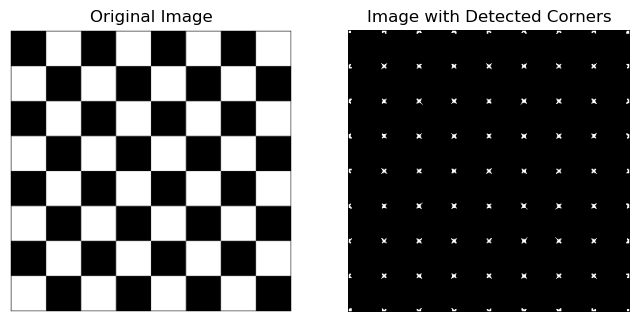

In [20]:
def cpu_harris_corner_detection(image, block_size=3, ksize=3, k=0.04, threshold=0.1):
    start_time = time.time()
    
    # Step 1: Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Apply Gaussian blur
    gray_blurred = cv2.GaussianBlur(gray, (3, 3), 1)

    # Step 3: Compute gradients
    grad_x = cv2.Sobel(gray_blurred, cv2.CV_32F, 1, 0, ksize=ksize)
    grad_y = cv2.Sobel(gray_blurred, cv2.CV_32F, 0, 1, ksize=ksize)

    # Step 4: Compute Harris response
    Ixx = grad_x * grad_x
    Iyy = grad_y * grad_y
    Ixy = grad_x * grad_y

    # Apply Gaussian blur to mixed derivatives
    Ixx = cv2.GaussianBlur(Ixx, (3, 3), 1)
    Iyy = cv2.GaussianBlur(Iyy, (3, 3), 1)
    Ixy = cv2.GaussianBlur(Ixy, (3, 3), 1)

    detM = Ixx * Iyy - Ixy * Ixy
    traceM = Ixx + Iyy
    harris_response = detM - k * (traceM ** 2)

    # Step 5: Thresholding
    _, harris_response_thresh = cv2.threshold(harris_response, threshold, 255, cv2.THRESH_BINARY)
    harris_response_thresh = harris_response_thresh.astype(np.uint8)

    # Step 6: Non-maximum Suppression
    nms_result = non_maximum_suppression(harris_response_thresh, window_size=3)
    end_time = time.time()
    time_taken = end_time - start_time
    print(f"Time taken for corner detection: {time_taken} seconds")
    return nms_result
    

def non_maximum_suppression(harris_response, window_size=3):
    # Create a copy to store NMS results
    nms = np.zeros_like(harris_response)

    # Define half window size
    offset = window_size // 2

    # Iterate over the image excluding the border pixels
    for y in range(offset, harris_response.shape[0] - offset):
        for x in range(offset, harris_response.shape[1] - offset):
            local_window = harris_response[y - offset:y + offset + 1, x - offset:x + offset + 1]
            local_max = np.max(local_window)
            if harris_response[y, x] == local_max and local_max != 0:
                nms[y, x] = 255

    return nms
    
def display_images(original_image, corners_image):
    plt.figure(figsize=(8, 4))

    # Original Image
    plt.subplot(121)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Image with Detected Corners
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(corners_image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Detected Corners')
    plt.axis('off')

    plt.show()
    
# Load image 
image = cv2.imread('C:\\Users\\Micha\\opencv_installation\\checkers.jpg')

# Perform CPU-based Harris Corner Detection
corners = cpu_harris_corner_detection(image)

display_images(image, corners)

Time taken for corner detection: 0.9431893825531006 seconds


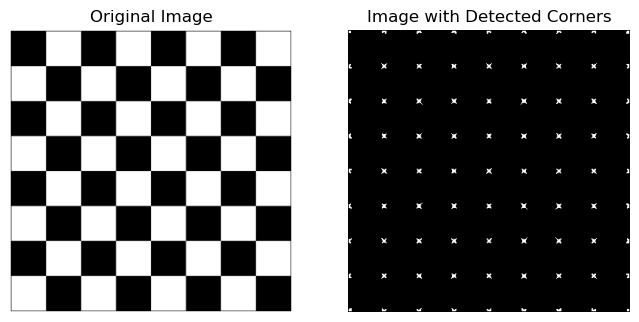

In [24]:
def non_maximum_suppression(harris_response, window_size=3):
    # Create a copy to store NMS results
    nms = np.zeros_like(harris_response)

    # Define half window size
    offset = window_size // 2

    # Iterate over the image excluding the border pixels
    for y in range(offset, harris_response.shape[0] - offset):
        for x in range(offset, harris_response.shape[1] - offset):
            local_window = harris_response[y - offset:y + offset + 1, x - offset:x + offset + 1]
            local_max = np.max(local_window)
            if harris_response[y, x] == local_max and local_max != 0:
                nms[y, x] = 255

    return nms
    
def cuda_harris_corner_detection(image, block_size=3, ksize=3, k=0.04, threshold=0.1):
   # Start the timer
    start_time = time.time()
    # Step 1: Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_gpu = cv2.cuda_GpuMat()
    gray_gpu.upload(gray)

    # Step 2: Apply Gaussian blur
    gaussian_filter = cv2.cuda.createGaussianFilter(cv2.CV_8UC1, cv2.CV_8UC1, (3, 3), 1)
    gray_blurred_gpu = gaussian_filter.apply(gray_gpu)

    # Step 3: Compute gradients
    sobel_filter_x = cv2.cuda.createSobelFilter(cv2.CV_8UC1, cv2.CV_32F, 1, 0, ksize=ksize)
    sobel_filter_y = cv2.cuda.createSobelFilter(cv2.CV_8UC1, cv2.CV_32F, 0, 1, ksize=ksize)

    grad_x = sobel_filter_x.apply(gray_blurred_gpu)
    grad_y = sobel_filter_y.apply(gray_blurred_gpu)

    # Update Gaussian filter for 32-bit float
    gaussian_filter_32f = cv2.cuda.createGaussianFilter(cv2.CV_32F, cv2.CV_32F, (3, 3), 1)

    # Step 4: Compute Harris response
    Ixx = cv2.cuda.multiply(grad_x, grad_x)
    Iyy = cv2.cuda.multiply(grad_y, grad_y)
    Ixy = cv2.cuda.multiply(grad_x, grad_y)

    Ixx = gaussian_filter_32f.apply(Ixx)
    Iyy = gaussian_filter_32f.apply(Iyy)
    Ixy = gaussian_filter_32f.apply(Ixy)

    detM = cv2.cuda.subtract(cv2.cuda.multiply(Ixx, Iyy), cv2.cuda.multiply(Ixy, Ixy))
    traceM = cv2.cuda.add(Ixx, Iyy)
    traceM2 = cv2.cuda.multiply(traceM, traceM)

    # Simplify scalar multiplication with k
   # Convert traceM2 to a numpy array, multiply by k, and upload back to GPU
    traceM2_host = traceM2.download()  # Download to host
    traceM2_host *= k  # Perform scalar multiplication on the host
    traceM2_k_gpu = cv2.cuda_GpuMat()  # Create a new GpuMat
    traceM2_k_gpu.upload(traceM2_host)  # Upload back to GPU
    
    # Now use traceM2_k_gpu in subtraction
    harris_response = cv2.cuda.subtract(detM, traceM2_k_gpu)

    # Step 5: Thresholding
    _, harris_response_thresh = cv2.cuda.threshold(harris_response, threshold, 255, cv2.THRESH_BINARY)

    # Download result to host memory
    harris_response_final = harris_response_thresh.download()
    harris_response_final = harris_response_final.astype(np.uint8)

    # Step 6: Non-maximum Suppression
    nms_result = non_maximum_suppression(harris_response_final, window_size=3)
    end_time = time.time()
    time_taken = end_time - start_time
    print(f"Time taken for corner detection: {time_taken} seconds")
    return nms_result

def display_images(original_image, corners_image):
    plt.figure(figsize=(8, 4))

    # Original Image
    plt.subplot(121)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Image with Detected Corners
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(corners_image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Detected Corners')
    plt.axis('off')

    plt.show()
    
# Load image
image = cv2.imread('C:\\Users\\Micha\\opencv_installation\\checkers.jpg')

# Perform CUDA Harris Corner Detection
corners = cuda_harris_corner_detection(image)

display_images(image, corners)


cProfile results:
Time taken for corner detection: 1.7689995765686035 seconds
         1107137 function calls (1107135 primitive calls) in 1.769 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.664    0.664    1.749    1.749 4103311837.py:1(non_maximum_suppression)
   138384    0.545    0.000    0.545    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   138384    0.160    0.000    0.771    0.000 fromnumeric.py:69(_wrapreduction)
   138384    0.137    0.000    0.908    0.000 fromnumeric.py:2638(amax)
   138384    0.082    0.000    1.085    0.000 <__array_function__ internals>:2(amax)
138387/138385    0.078    0.000    0.986    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   138384    0.051    0.000    0.051    0.000 fromnumeric.py:70(<dictcomp>)
   138384    0.018    0.000    0.018    0.000 fromnumeric.py:2633(_amax_dispatcher)
   138384    0.014    0.000    0.014    0.000 {me

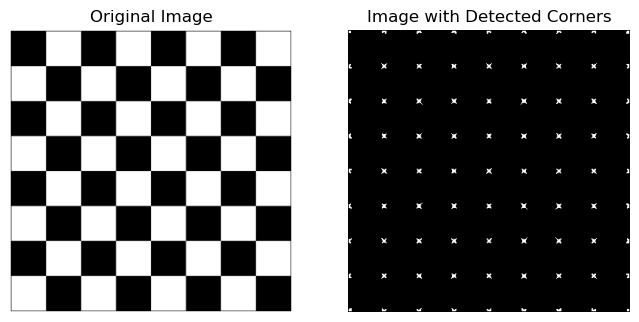

cProfile results:

line_profiler results:
Time taken for corner detection: 2.2201592922210693 seconds

memory_profiler results:
Time taken for corner detection: 0.9182498455047607 seconds
peak memory: 815.68 MiB, increment: 0.00 MiB


Timer unit: 1e-07 s

Total time: 2.21937 s
File: C:\Users\Micha\AppData\Local\Temp\ipykernel_19196\4103311837.py
Function: cuda_harris_corner_detection at line 19

Line #      Hits         Time  Per Hit   % Time  Line Contents
    19                                           def cuda_harris_corner_detection(image, block_size=3, ksize=3, k=0.04, threshold=0.1):
    20         1         18.0     18.0      0.0      start_time = time.time()
    21                                               
    22                                               # Convert to grayscale and upload to GPU
    23         1       3889.0   3889.0      0.0      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    24         1         71.0     71.0      0.0      gray_gpu = cv2.cuda_GpuMat()
    25         1       4588.0   4588.0      0.0      gray_gpu.upload(gray)
    26                                           
    27                                               # Apply Gaussian blur (using optimized CUDA functio

In [19]:
def non_maximum_suppression(harris_response, window_size=3):
    # Create a copy to store NMS results
    nms = np.zeros_like(harris_response)

    # Define half window size
    offset = window_size // 2

    # Iterate over the image excluding the border pixels
    for y in range(offset, harris_response.shape[0] - offset):
        for x in range(offset, harris_response.shape[1] - offset):
            local_window = harris_response[y - offset:y + offset + 1, x - offset:x + offset + 1]
            local_max = np.max(local_window)
            if harris_response[y, x] == local_max and local_max != 0:
                nms[y, x] = 255

    return nms
    

def cuda_harris_corner_detection(image, block_size=3, ksize=3, k=0.04, threshold=0.1):
    start_time = time.time()
    
    # Convert to grayscale and upload to GPU
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_gpu = cv2.cuda_GpuMat()
    gray_gpu.upload(gray)

    # Apply Gaussian blur (using optimized CUDA function)
    gaussian_filter = cv2.cuda.createGaussianFilter(cv2.CV_8UC1, cv2.CV_8UC1, (3, 3), 1)
    gray_blurred_gpu = gaussian_filter.apply(gray_gpu)

    # Compute gradients (using optimized CUDA function)
    sobel_filter_x = cv2.cuda.createSobelFilter(cv2.CV_8UC1, cv2.CV_32F, 1, 0, ksize=ksize)
    sobel_filter_y = cv2.cuda.createSobelFilter(cv2.CV_8UC1, cv2.CV_32F, 0, 1, ksize=ksize)
    grad_x = sobel_filter_x.apply(gray_blurred_gpu)
    grad_y = sobel_filter_y.apply(gray_blurred_gpu)

    # Update Gaussian filter for 32-bit float
    gaussian_filter_32f = cv2.cuda.createGaussianFilter(cv2.CV_32F, cv2.CV_32F, (3, 3), 1)

    # Compute Harris response
    Ixx = cv2.cuda.multiply(grad_x, grad_x)
    Iyy = cv2.cuda.multiply(grad_y, grad_y)
    Ixy = cv2.cuda.multiply(grad_x, grad_y)

    Ixx = gaussian_filter_32f.apply(Ixx)
    Iyy = gaussian_filter_32f.apply(Iyy)
    Ixy = gaussian_filter_32f.apply(Ixy)

    detM = cv2.cuda.subtract(cv2.cuda.multiply(Ixx, Iyy), cv2.cuda.multiply(Ixy, Ixy))
    traceM = cv2.cuda.add(Ixx, Iyy)
    harris_response = cv2.cuda.subtract(detM, cv2.cuda.multiply(traceM, traceM, scale=k))

    # Thresholding
    _, harris_response_thresh = cv2.cuda.threshold(harris_response, threshold, 255, cv2.THRESH_BINARY)

    # Download result to host memory for NMS
    harris_response_final = harris_response_thresh.download().astype(np.uint8)

    # Non-maximum Suppression
    nms_result = non_maximum_suppression(harris_response_final, window_size=3)
    
    end_time = time.time()
    time_taken = end_time - start_time
    print(f"Time taken for corner detection: {time_taken} seconds")
    
    return nms_result

def profiled_cuda_harris_corner_detection(image):
    pr = cProfile.Profile()
    pr.enable()

    result = cuda_harris_corner_detection(image)

    pr.disable()
    pr.print_stats(sort='time')

    return result
    
def display_images(original_image, corners_image):
    plt.figure(figsize=(8, 4))

    # Original Image
    plt.subplot(121)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Image with Detected Corners
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(corners_image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Detected Corners')
    plt.axis('off')

    plt.show()

# Load image
image = cv2.imread('C:\\Users\\Micha\\opencv_installation\\checkers.jpg')

# Perform CUDA Harris Corner Detection and profile the function
print("cProfile results:")
corners = profiled_cuda_harris_corner_detection(image)

# Display the images
display_images(image, corners)

print("cProfile results:")
# Profile the function using line_profiler
print("\nline_profiler results:")
%lprun -f cuda_harris_corner_detection cuda_harris_corner_detection(image)

# Profile the function using memory_profiler
print("\nmemory_profiler results:")
%memit cuda_harris_corner_detection(image)
